# Finding Neighbourhoods in Street Networks

In [1]:
# https://stackoverflow.com/questions/60367378/finding-neighbourhoods-cliques-in-street-data-a-graph

## Answer 1: Treat as Image Segmentation Problem

In [4]:
#!/usr/bin/env python
# coding: utf-8

"""
Find house blocks in osmnx graphs.
"""

In [1]:
import numpy as np
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from skimage.measure import label, find_contours, points_in_poly
from skimage.color import label2rgb

In [2]:
ox.config(log_console=True, use_cache=True)

In [3]:
def k_core(G, k):
    H = nx.Graph(G, as_view=True)
    H.remove_edges_from(nx.selfloop_edges(H))
    core_nodes = nx.k_core(H, k)
    H = H.subgraph(core_nodes)
    return G.subgraph(core_nodes)

In [4]:
def plot2img(fig):
    # remove margins
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    # convert to image
    # https://stackoverflow.com/a/35362787/2912349
    # https://stackoverflow.com/a/54334430/2912349
    canvas = FigureCanvas(fig)
    canvas.draw()
    img_as_string, (width, height) = canvas.print_to_buffer()
    as_rgba = np.fromstring(img_as_string, dtype='uint8').reshape((height, width, 4))
    return as_rgba[:,:,:3]

In [5]:
location_point = (53.4, -2.93)
# G = ox.graph_from_point(location_point, 500)
# G_projected = ox.project_graph(G)
# ox.save_graphml(G_projected, filename='network.graphml')

G = ox.load_graphml('network.graphml')

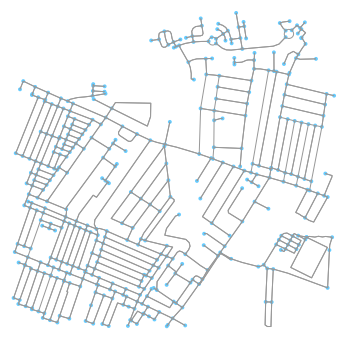

(<Figure size 430.084x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f117e3669a0>)

In [6]:
ox.plot_graph(G)

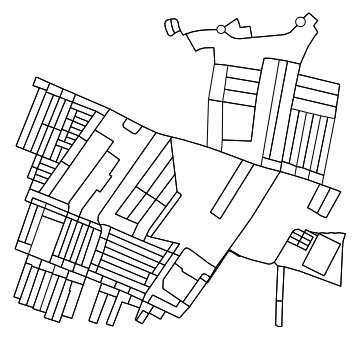

In [52]:
H = k_core(G, 2)
fig1, ax1 = ox.plot_graph(H, node_size=0, edge_color='k', edge_linewidth=1)

<ipython-input-4-fef096bffb32>:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  as_rgba = np.fromstring(img_as_string, dtype='uint8').reshape((height, width, 4))
<ipython-input-53-0d53ea98d582>:3: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  image_label_overlay = label2rgb(label_image[:,:,0], image=img[:,:,0])


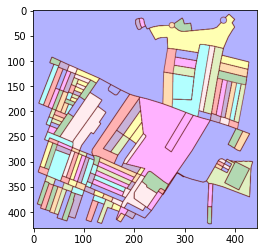

In [53]:
img = plot2img(fig1)
label_image = label(img > 170)
image_label_overlay = label2rgb(label_image[:,:,0], image=img[:,:,0])
fig, ax = plt.subplots(1,1)
ax.imshow(image_label_overlay)

In [54]:
import matplotlib.cm as cm
# get color map
cmap = cm.get_cmap('tab20c', len(np.unique(label_image.ravel())) + 1)

In [55]:
# using a large region here as an example;
# however we could also loop over all unique labels, i.e.
for ii in np.unique(label_image.ravel()):
# ii = np.argsort(np.bincount(label_image.ravel()))[-5]

    mask = (label_image[:,:,0] == ii)
    contours = find_contours(mask.astype(np.float), 0.5)

    # Select the largest contiguous contour
    contour = sorted(contours, key=lambda x: len(x))[-1]

    # display the image and plot the contour;
    # this allows us to transform the contour coordinates back to the original data cordinates
    fig2, ax2 = plt.subplots()
    ax2.imshow(mask, interpolation='nearest', cmap='gray')
    ax2.autoscale(enable=False)
    ax2.step(contour.T[1], contour.T[0], linewidth=2, c='r')
    plt.close(fig2)

    # first column indexes rows in images, second column indexes columns;
    # therefor we need to swap contour array to get xy values
    contour = np.fliplr(contour)

    pixel_to_data = ax2.transData + ax2.transAxes.inverted() \
                + ax1.transAxes + ax1.transData.inverted()
    transformed_contour = pixel_to_data.transform(contour)
    transformed_contour_path = Path(transformed_contour, closed=True)
    patch = PathPatch(transformed_contour_path, facecolor=cmap.colors[ii])
    ax1.add_patch(patch)

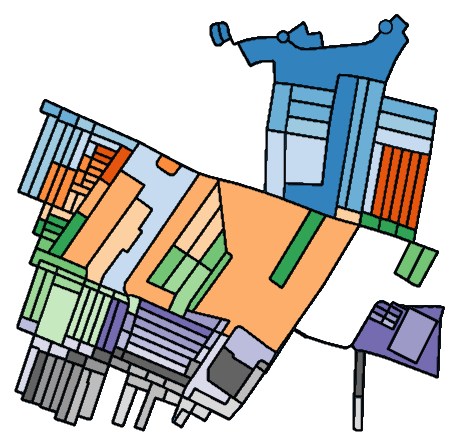

In [56]:
fig1

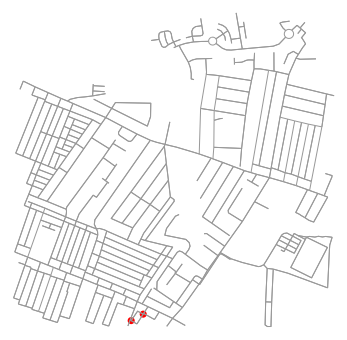

In [31]:
x = G.nodes.data('x')
y = G.nodes.data('y')
xy = np.array([(x[node], y[node]) for node in G.nodes])
eps = (xy.max(axis=0) - xy.min(axis=0)).mean() / 100
is_inside = transformed_contour_path.contains_points(xy, radius=-eps)
nodes_inside_block = [node for node, flag in zip(G.nodes, is_inside) if flag]

node_size = [50 if node in nodes_inside_block else 0 for node in G.nodes]
node_color = ['r' if node in nodes_inside_block else 'k' for node in G.nodes]
fig3, ax3 = ox.plot_graph(G, node_color=node_color, node_size=node_size)

In [13]:
if set(nodes_inside_block_1) & set(nodes_inside_block_2): # empty set evaluates to False
    print("Blocks are neighbors.")

NameError: name 'nodes_inside_block_1' is not defined